# Bagging
Part 2 of the course project in *Artificial intelligence applied to engineering* at ETSEIB, UPC, spring 2024. The team members contributing to the deliverable is 
- Lise Jakobsen
- Julie Sørlie Lund
- Magnus Ingnes Sagmo

The dataset used in this deliverable can be retrieved from [Kaggle](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset).

## Data set review

#### Target class
The target class, `HeartDisease`, is a boolean class telling whether the patient has a heart disease. Subsequently, this is a classification problem.

#### Features
The data set has 11 features. Two of these, `ChestPainType` and `RestingECG`, are one-hot encoded. 

#### Preprocessing method
Before applying KNN
- zero values of `Cholesterol` are imputed using `sklearn.impute.KNNImputer`.
- the data is split into train and test set using `sklearn.model_selection.train_test_split`.
- the data is normalized using `sklearn.preprocessing.StandardScaler`.

In addition, we will try to both keep and remove outliers to see what produces best predictions. 

## Performance metrics

#### Recall
In the case of detecting heart diseases it is crucial to minimize the number of false negatives (people with a heart disease going unnoticed). We will therefore focus on minimizing recall.

#### F1-score
By solely focusing on recall, we can end with a too high number of false positives (by choosing a model that classifies everything as heart disease). We will therefore also look at the F1-score, as it offers a balance between precision and recall. 

#### Precision-recall curve
The precision-recall curve is a good way to visualize how well the model balances precision and recall. 

#### Confusion matrix
A good way to look at the number of false positives is looking at the confusion matrix. This will allow us to simultaneously look at false negatives, true positives and true negatives. 


## Hyperparameters

#### n-estimators
This is the number of base estimators in the ensemble. Increasing the number of estimators generally improves performance but also increases computational cost.

#### max_samples
This determines the number of samples to draw from the dataset to train each base estimator. Adjusting this can help in controlling overfitting and underfitting.

#### max_features
This controls the number of features to draw from the dataset for each base estimator. Like max_samples, tuning this parameter can help in managing overfitting and underfitting.

#### bootstrap
This parameter controls whether sampling is done with replacement. It impacts the diversity of the base estimators. Using bootstrap sampling (with replacement) typically helps in reducing variance, whereas not using it (without replacement) can sometimes improve performance depending on the dataset.

### Load data

We will split the data in training and test set, and only use the train data for the cross validation in the grid search. This will reduce the amount of data used to train the models and tuning hyperparameters, butt will ensure no data leakage and help reduce overfitting of the model. 

In [31]:
%load_ext autoreload
%autoreload 2

from preprocessor import Preprocessor
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score, precision_recall_curve, auc, precision_score
import numpy as np
import pandas as pd
from sklearn.model_selection import validation_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
prep = Preprocessor()

X_train, X_test, y_train, y_test = prep.get_data(test_size=0.25, impute_method='knn', remove_outliers=True, scaling_method='standard')

### Set up hyperparameters grid

We will explore
- `n_estimators`: The number of base estimators (decision trees) in the ensemble.
- `max_samples`: The number of samples to draw from the dataset to train each base estimator. For example, 0.5 means each base estimator will be trained on 50% of the dataset.
- `max_features`: The number of features to draw from the dataset to train each base estimator. For example, 0.5 means each base estimator will use 50% of the features.
- `bootstrap`: Bagging/sampling with replacement (True) or Pasting/sampling without replacement (False).

In [33]:
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False]
}

### Perform grid search

As stated above, we will focus mainly on recall and F1-score for our model evaluation. For the grid search we will use F1-score as evaluation metric, because
- using recall can cause an unacceptably poor precision.
- F1-score also considers true positives.

To narrow the number of combinations we will further evaluate, we retrieve the six best combinations from the grid search.

In [34]:
# Define model
bagging = BaggingClassifier(random_state=2)

# Perform grid search
grid_search = GridSearchCV(bagging, param_grid, cv=5, scoring='f1', return_train_score=True)
grid_search.fit(X_train, y_train)

# Extract the six best iterations, based on mean F1 score
results = pd.DataFrame(grid_search.cv_results_)
top_6 = results.nlargest(6, 'mean_test_score')  
# Extract only the interesting columns from the DataFrame
# Adjust the column names based on the parameters used in the grid search
top_6 = top_6[['param_n_estimators', 'param_max_samples', 'param_max_features', 'param_bootstrap', 'mean_test_score', 'std_test_score']]

top_6

,param_n_estimators,param_max_samples,param_max_features,param_bootstrap,mean_test_score,std_test_score
6,100,0.7,0.5,True,0.876170,0.019892
7,200,0.7,0.5,True,0.875399,0.024151
13,50,0.5,0.7,True,0.875163,0.043593
2,100,0.5,0.5,True,0.874668,0.024663
3,200,0.5,0.5,True,0.873346,0.026337
42,100,0.7,0.5,False,0.872441,0.025138


### TODO
The six best combinations using F1-score are
- in the range 9-31 for `n_neighbors`.
- all the best are using Manhattan distance.

The combination of hyperparameters with the highest mean F1 score from the grid search uses `n_neighbors=13`. Having a relatively low n as the top performer is a good sign, as it avoids overfitting of the model. This combination also has the lowest standard deviation, showing a stable performance across different folds.

### Evaluating top 6 combinations
We will continue by examining how these six top results perform on unseen data. We will look at 
- F1-score
- Recall
- Precision
- Precision-Recall Area Under Curve

In [35]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    # Make prediction
    y_pred = model.predict(X_test)

    # Retrieve scores
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    pr_auc = auc(recall_curve, precision_curve)

    return recall, f1, precision, pr_auc

In [36]:
# DataFrame with evaluation metric for each of the top 6 models
evaluation_results = pd.DataFrame(columns=['param_n_estimators', 'param_max_samples', 'param_max_features', 'param_bootstrap', 'Recall', 'Precision', 'F1-score', 'Precision-recall AUC'])

# Iterate the top 6 parameter combinations
for (index, row) in top_6.iterrows():

    # Dict with params from the row
    params = {
        'n_estimators': row['param_n_estimators'],
        'max_samples': row['param_max_samples'],
        'max_features': row['param_max_features'],
        'bootstrap': row['param_bootstrap']
    }

    # Fit the model with params
    model = BaggingClassifier(n_estimators=params['n_estimators'], max_samples=params['max_samples'], max_features=params['max_features'], bootstrap=params['bootstrap'], random_state=1)
    model.fit(X_train, y_train)
    
    # Evaluate the model
    recall, f1, precision, pr_auc = evaluate_model(model, X_test, y_test)

    new_row = {
        'param_n_estimators': params['n_estimators'],
        'param_max_samples': params['max_samples'],
        'param_max_features': params['max_features'],
        'param_bootstrap': params['bootstrap'],
        'Recall': round(recall, 3), 
        'Precision': round(precision, 3), 
        'F1-score': round(f1, 3), 
        'Precision-recall AUC': round(pr_auc, 3)
    }
    evaluation_results.loc[len(evaluation_results)] = new_row

evaluation_results = evaluation_results.sort_values(by=['Recall', 'F1-score'])
evaluation_results

,param_n_estimators,param_max_samples,param_max_features,param_bootstrap,Recall,Precision,F1-score,Precision-recall AUC
5,100,0.7,0.5,False,0.835,0.895,0.864,0.935
0,100,0.7,0.5,True,0.835,0.910,0.871,0.939
2,50,0.5,0.7,True,0.842,0.926,0.882,0.943
1,200,0.7,0.5,True,0.865,0.906,0.885,0.942
3,100,0.5,0.5,True,0.865,0.913,0.888,0.935
4,200,0.5,0.5,True,0.872,0.913,0.892,0.937


From the results on the unseen data, we will further evaluate a model using `n_neighbors=9` and `p=1`. This is due to the following considerations:
- The Recall rate is tied second best, and only insignificantly lower (0.008) than the best. 
- The F1-score is tied second best, and only insignificantly lower (0.004) than the best. 
- While performing approximately as well, this combination has significantly lower n than the top performers (9 compared to 29 and 31). By choosing this, we will get a model that is both less computationally expensive and less prone to overfitting, without compromising the results.

### Bias and variance

Next, we examine the model performance in the context of bias and variance by plotting a validation curve for n in the range 1 to 29.

In [37]:
def plot_validation_curve(param_name, param_range):
    # Calculate scores for validation curve
    train_scores, test_scores = validation_curve(
        BaggingClassifier(random_state=3),
        X_train, y_train, param_name=param_name, 
        param_range=param_range,
        cv=5, scoring="recall", n_jobs=-1)

    # Calculate mean and standard deviation for train and test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(6, 3))
    plt.plot(param_range, train_mean, label="Training score", color="r")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="g")

    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

    plt.title("Validation Curve for Bagging, recall")
    plt.xlabel(f"{param_name}")
    plt.ylabel("Recall")
    plt.legend(loc="best")
    plt.show()

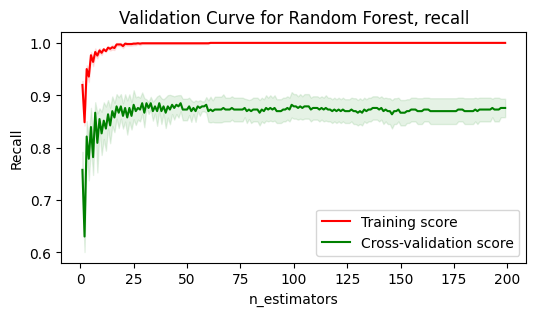

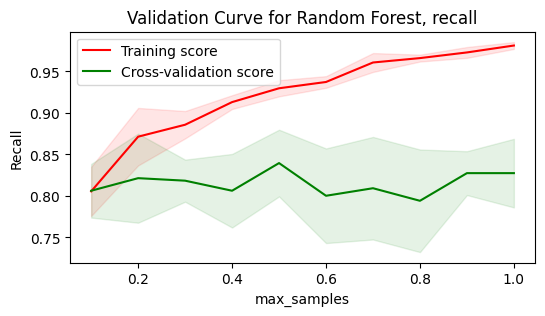

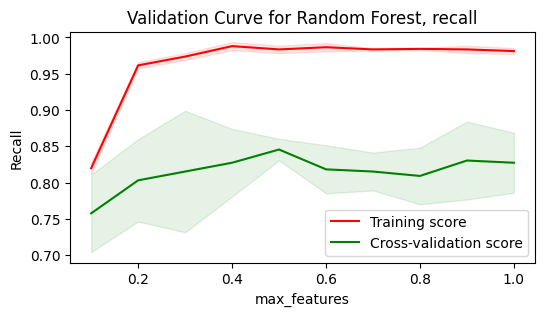

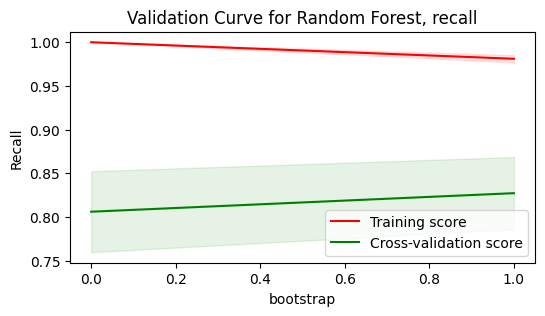

In [39]:
md_range = np.arange(1, 200)
plot_validation_curve('n_estimators', md_range)

split_range = np.arange(0.1, 1.1, 0.1)  
plot_validation_curve('max_samples', split_range)

leaf_range = np.arange(0.1, 1.1, 0.1)  
plot_validation_curve('max_features', leaf_range)

bootstrap_range = [True, False]
plot_validation_curve('bootstrap', bootstrap_range)

# 'n_estimators': [10, 50, 100, 200],
#     'max_samples': [0.5, 0.7, 1.0],
#     'max_features': [0.5, 0.7, 1.0],
#     'bootstrap': [True, False]

#### n_estimators
The training score increases steadily with the number of estimators, while the cross-validation score plateaus or increases slightly and then stabilizes. Adding more estimators generally improves performance on the training set but may not significantly improve generalization performance beyond a certain point. Increasing n_estimators too much can lead to longer training times without much improvement in validation scores.

#### max_samples
Both the training and cross-validation scores decrease as the value of max_samples increases. The decrease is more pronounced for the training score.
Allowing more samples to be used for training each base estimator reduces overfitting, as indicated by the decreasing training score. However, there's a tradeoff, as reducing max_samples too much may lead to underfitting. The optimal value likely lies somewhere in the middle range of the parameter values.

#### max_features
Both the training and cross-validation scores initially increase as max_features increases, but then they plateau or decrease slightly.
Allowing more features to be used for training each base estimator initially improves performance, as indicated by the increasing scores. However, beyond a certain point, increasing max_features too much can lead to overfitting. The optimal value is likely somewhere in the middle range of the parameter values.

#### bootstrap
The training score is higher when bootstrap is set to True compared to when it's False, while the cross-validation score is lower. Enabling bootstrapping (bootstrap=True) leads to better performance on the training set but worse performance on the validation set. This suggests that bootstrapping may introduce more variance into the model, leading to overfitting. Disabling bootstrapping (bootstrap=False) could result in a more stable model with better generalization performance.

#### Overall Conclusion
Model Complexity: The hyperparameters n_estimators, max_samples, and max_features control the complexity of the Bagging ensemble. Increasing these hyperparameters can lead to higher model complexity, potentially resulting in overfitting.
Regularization: The hyperparameter bootstrap acts as a form of regularization. Enabling bootstrapping introduces randomness into the training process, which can help prevent overfitting.
Optimization Tradeoffs: There are tradeoffs associated with each hyperparameter. Finding the optimal values requires balancing between model complexity and generalization performance.
Validation Curve Analysis: By analyzing the validation curves, we can understand how each hyperparameter affects model performance and make informed decisions about hyperparameter tuning.